In [27]:
import Data.dataset as ds
import Plots.plots as pl
import Calculations.monte_carlo as mc
from fitter import Fitter, get_common_distributions, get_distributions


import numpy as np 
import statsmodels.api as sm 
import pylab as py

In [28]:
zone1 = ds.get_out1()
zone2 = ds.get_out2()

mass = ('Mass', 'Mass [kg]')
velocity = ('Velocity', 'Velocity [m/s]')
kinetic_energy = ('Kinetic Energy', 'Kinetic Energy [kJ]')
timedelta = ('Timedelta', 'TimeDiffHours')
n_years = 10000

In [29]:
without_outliers_zone1 = ds.replace_outliers_with_median(zone1)
without_outliers_zone2 = ds.replace_outliers_with_median(zone2)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.009305,1083.141638,1089.800161,inf,0.136433,0.144822
expon,0.011535,1060.303179,1064.742194,inf,0.116051,0.295644
exponpow,0.013617,991.751234,998.409757,inf,0.204460,0.005713
rayleigh,0.016292,1067.605966,1072.044981,inf,0.168988,0.036290
norm,0.017017,1082.647998,1087.087014,inf,0.137568,0.138696


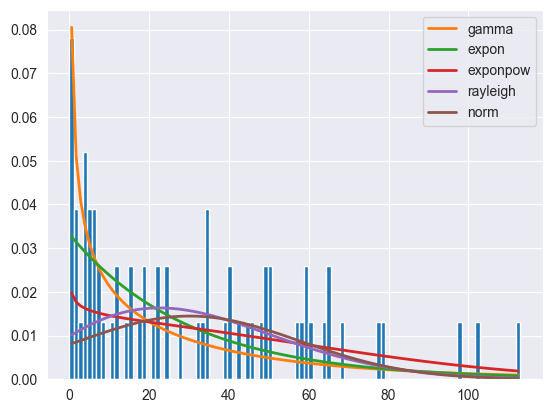

In [30]:
#zone1 timedelta
f = Fitter(without_outliers_zone1['TimeDiffHours'], distributions=get_common_distributions())
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.021030,1148.200866,1151.132338,inf,0.159221,0.353865
gamma,0.021276,1062.860806,1067.258014,inf,0.105899,0.828831
rayleigh,0.021387,1064.071694,1067.003166,inf,0.159575,0.351265
norm,0.021812,1081.940933,1084.872405,inf,0.184484,0.199670
expon,0.022784,1063.079888,1066.011360,inf,0.224790,0.066752


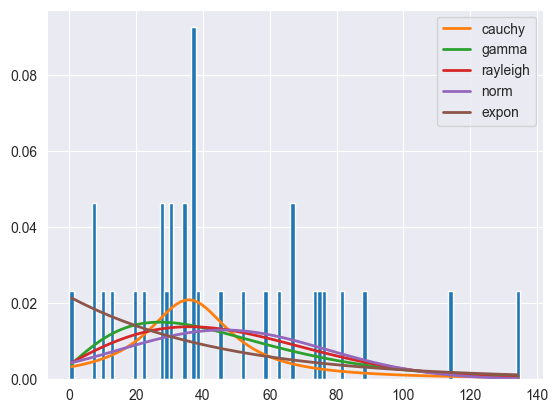

In [31]:
#zone2 timedelta
f = Fitter(without_outliers_zone2['TimeDiffHours'], distributions=get_common_distributions())
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,1.007418,559.582300,564.021316,inf,0.059355,0.958730
lognorm,1.007418,561.582245,568.240768,inf,0.059355,0.958727
gamma,1.010142,560.352868,567.011391,inf,0.063807,0.928074
chi2,1.017533,558.084152,564.742675,inf,0.075881,0.800376
exponpow,1.047920,542.377735,549.036258,inf,0.073655,0.827877


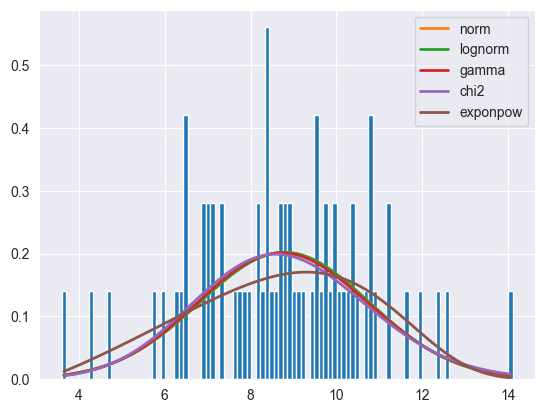

In [32]:
#zone1 velocity
f = Fitter(without_outliers_zone1['Velocity [m/s]'], distributions=get_common_distributions())
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.607154,675.068739,678.000211,inf,0.104641,0.839121
lognorm,0.607154,677.069040,681.466248,inf,0.104643,0.839108
chi2,0.608647,677.413072,681.810279,inf,0.113398,0.763308
gamma,0.608798,677.225194,681.622402,inf,0.113424,0.763071
uniform,0.622910,618.538663,621.470135,inf,0.221065,0.074555


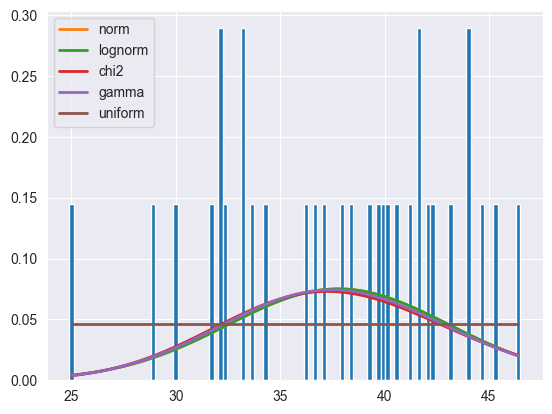

In [33]:
#zone2 velocity
f = Fitter(without_outliers_zone2['Velocity [m/s]'], distributions=get_common_distributions())
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000100,1574.328496,1580.987020,inf,0.106740,0.393001
cauchy,0.000100,1673.119020,1677.558036,inf,0.142975,0.112314
gamma,0.000102,1562.591105,1569.249628,inf,0.119644,0.263002
chi2,0.000102,1562.591093,1569.249616,inf,0.119644,0.263002
rayleigh,0.000111,1572.933925,1577.372941,inf,0.214867,0.003102


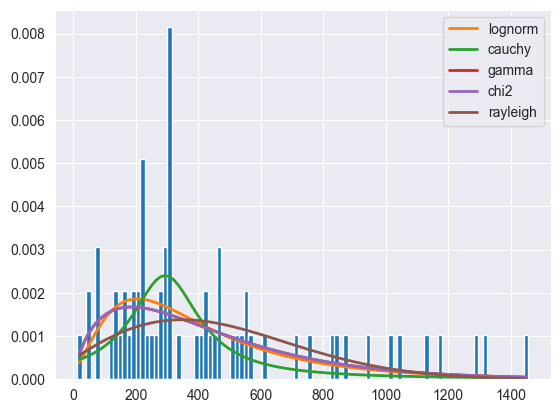

In [34]:
#zone1 mass
f = Fitter(without_outliers_zone1['Mass [kg]'], distributions=get_common_distributions())
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.008701,1318.796262,1321.727734,inf,0.148463,0.438699
gamma,0.009328,1197.606758,1202.003966,inf,0.153161,0.400301
rayleigh,0.009491,1202.652001,1205.583472,inf,0.255145,0.025258
expon,0.009601,1195.788897,1198.720369,inf,0.183847,0.202795
exponpow,0.009609,1170.468891,1174.866099,inf,0.183749,0.203279


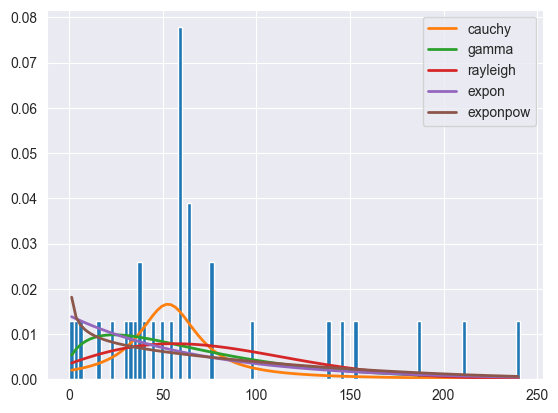

In [35]:
#zone2 mass
f = Fitter(without_outliers_zone2['Mass [kg]'], distributions=get_common_distributions())
f.fit()

f.summary()

Zone1 Timedelta


,TimeDiffHours
0,0.0
1,38.0
2,42.0
3,9.0
4,23.0
...,...
2910131,5.0
2910132,23.0
2910133,103.0
2910134,18.0


Zone2 Timedelta


,TimeDiffHours
0,0.0
1,17.0
2,53.0
3,5.0
4,14.0
...,...
1902058,26.0
1902059,57.0
1902060,52.0
1902061,24.0


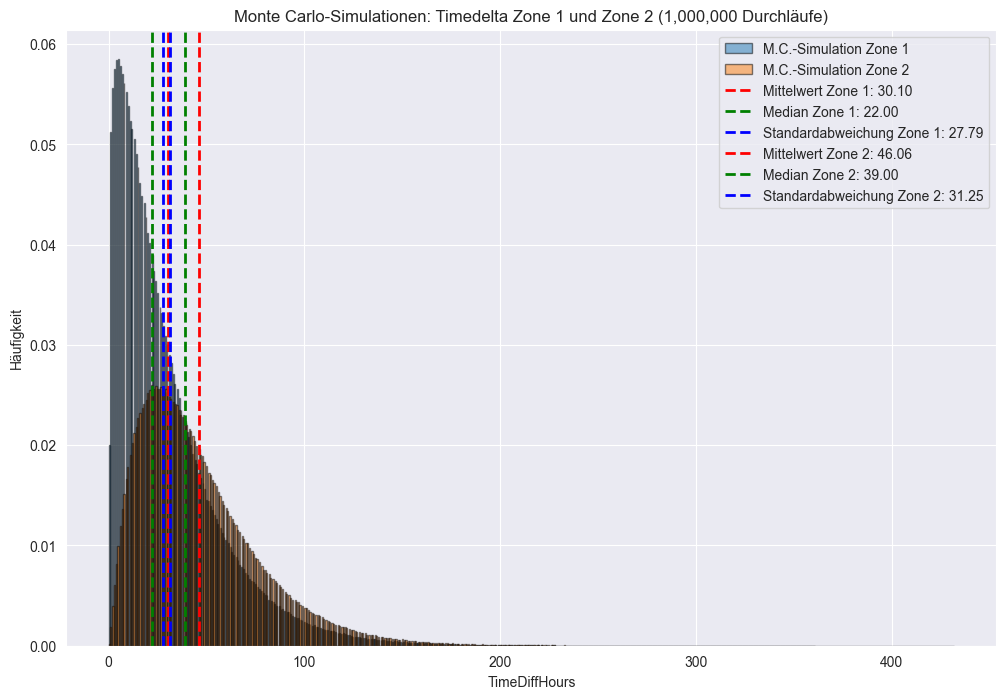

In [36]:
print('Zone1 Timedelta')
sim_timediff_zone1 = mc.simulate_gamma_distribution_timediff(without_outliers_zone1, n_years, timedelta)
display(sim_timediff_zone1)

print('Zone2 Timedelta')
sim_timediff_zone2 = mc.simulate_gamma_distribution_timediff(without_outliers_zone2, n_years, timedelta)
display(sim_timediff_zone2)

pl.show_simulated_data(sim_timediff_zone1, sim_timediff_zone2, timedelta)

n_simulations_zone1 = len(sim_timediff_zone1)
n_simulations_zone2 = len(sim_timediff_zone2)

Zone1 Velocity


,Velocity [m/s]
0,9.091955
1,10.421224
2,6.531446
3,11.145501
4,8.696097
...,...
2910131,8.592849
2910132,8.359215
2910133,6.446861
2910134,10.319851


Zone2 Velocity


,Velocity [m/s]
0,32.038636
1,41.398070
2,44.816839
3,35.409119
4,42.163084
...,...
1902058,45.177166
1902059,41.768183
1902060,35.603575
1902061,31.177076


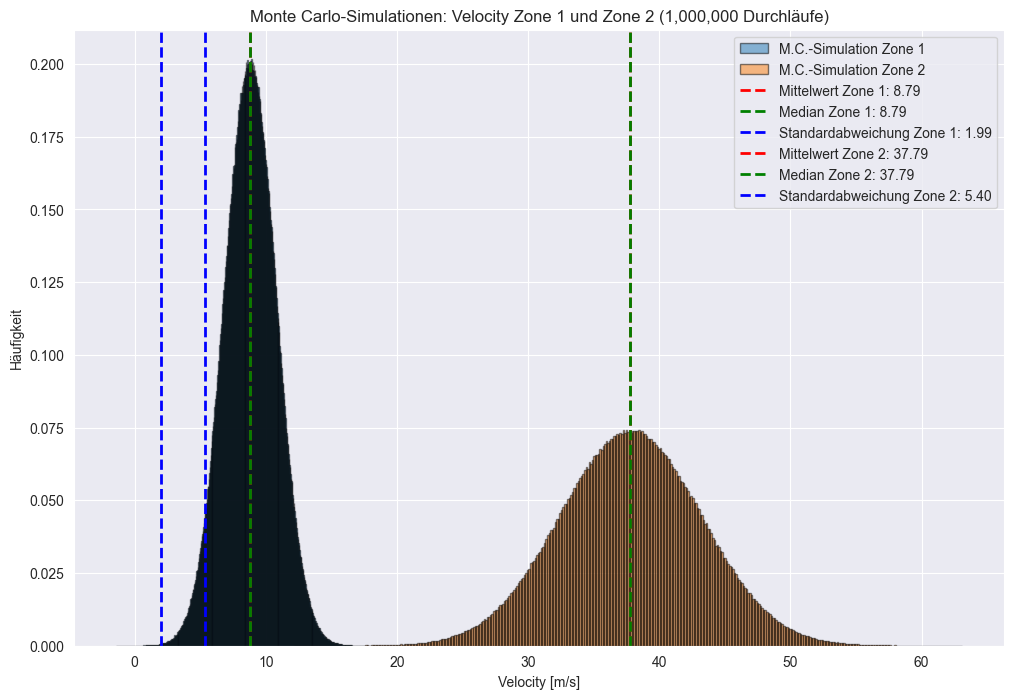

In [37]:
print('Zone1 Velocity')
sim_velocity_zone1 = mc.simulate_norm_distribution(without_outliers_zone1, n_simulations_zone1, velocity)
display(sim_velocity_zone1)

print('Zone2 Velocity')
sim_velocity_zone2 = mc.simulate_norm_distribution(without_outliers_zone2, n_simulations_zone2, velocity)
display(sim_velocity_zone2)

pl.show_simulated_data(sim_velocity_zone1, sim_velocity_zone2, velocity)

Zone1 Mass


,Mass [kg]
0,685.393689
1,294.733064
2,413.587163
3,294.278154
4,340.035377
...,...
2910131,73.489385
2910132,204.559753
2910133,430.466413
2910134,305.714705


Zone2 Mass


,Mass [kg]
0,27.461722
1,245.733189
2,45.275498
3,3.242748
4,58.454878
...,...
1902058,74.603183
1902059,66.332833
1902060,66.496432
1902061,75.172473


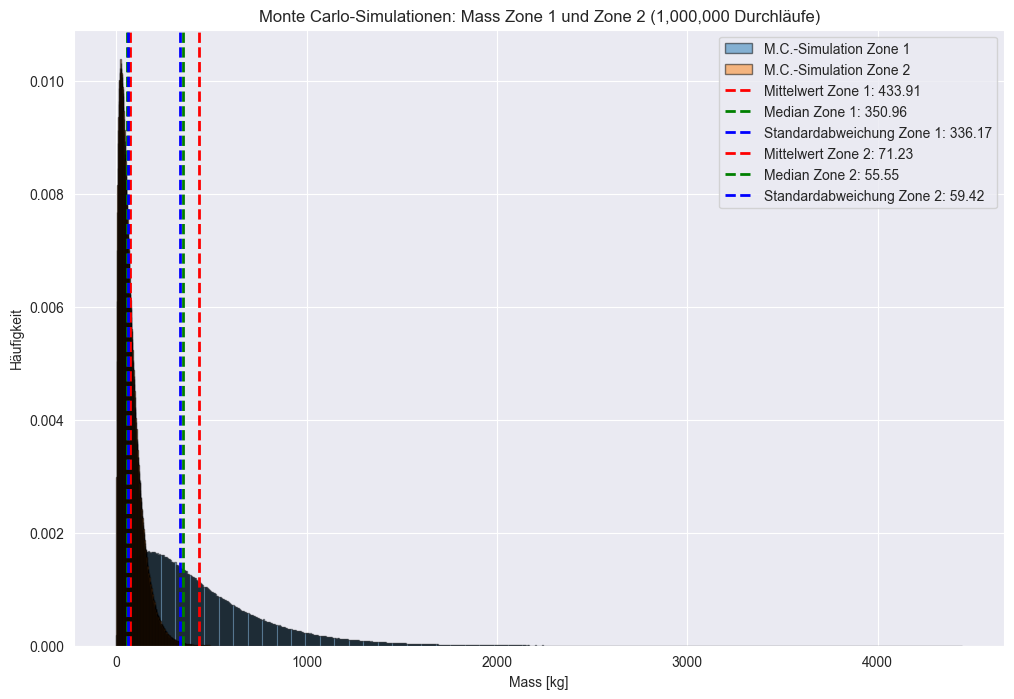

In [38]:
print('Zone1 Mass')
sim_mass_zone1 = mc.simulate_gamma_distribution(without_outliers_zone1, n_simulations_zone1, mass)
display(sim_mass_zone1)

print('Zone2 Mass')
sim_mass_zone2 = mc.simulate_gamma_distribution(without_outliers_zone2, n_simulations_zone2, mass)
display(sim_mass_zone2)

pl.show_simulated_data(sim_mass_zone1, sim_mass_zone2, mass)

Zone1


,Mass [kg],Velocity [m/s],Kinetic Energy [kJ]
0,685.393689,9.091955,28.328573
1,294.733064,10.421224,16.004287
2,413.587163,6.531446,8.821769
3,294.278154,11.145501,18.277939
4,340.035377,8.696097,12.857095
...,...,...,...
2910131,73.489385,8.592849,2.713120
2910132,204.559753,8.359215,7.146958
2910133,430.466413,6.446861,8.945525
2910134,305.714705,10.319851,16.279205


Zone2


,Mass [kg],Velocity [m/s],Kinetic Energy [kJ]
0,27.461722,32.038636,14.094375
1,245.733189,41.398070,210.568797
2,45.275498,44.816839,45.469029
3,3.242748,35.409119,2.032888
4,58.454878,42.163084,51.958367
...,...,...,...
1902058,74.603183,45.177166,76.131664
1902059,66.332833,41.768183,57.861503
1902060,66.496432,35.603575,42.145923
1902061,75.172473,31.177076,36.534200


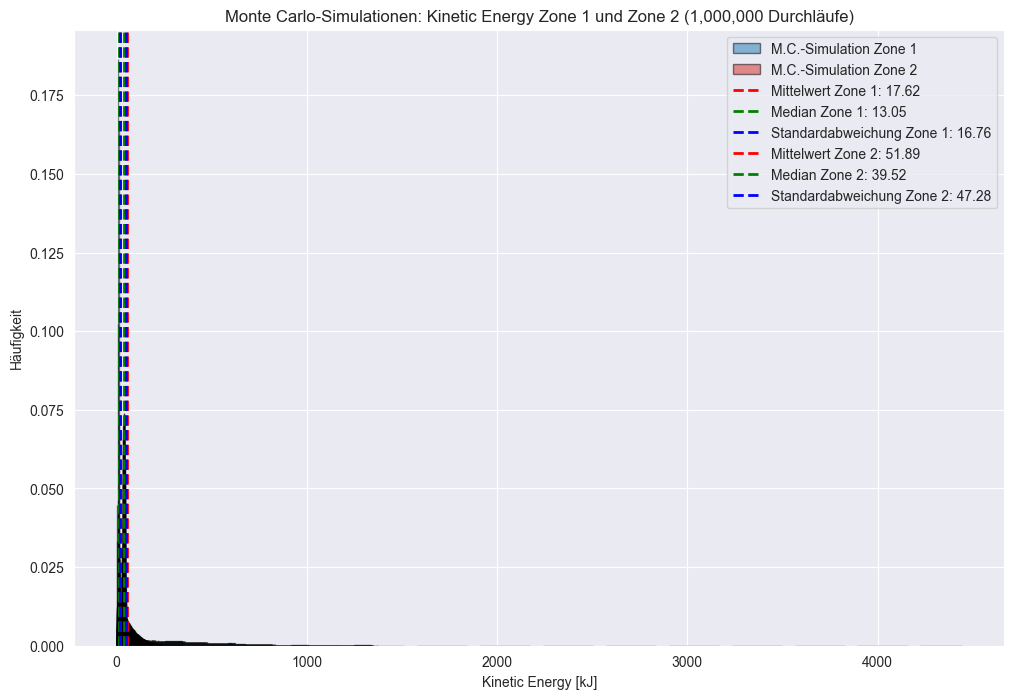

In [39]:
merged_zone1 = ds.merge_simulated_data(sim_mass_zone1, sim_velocity_zone1)
merged_zone2 = ds.merge_simulated_data(sim_mass_zone2, sim_velocity_zone2)

print('Zone1')
display(merged_zone1)
print('Zone2')
display(merged_zone2)

pl.show_simulated_data(merged_zone1, merged_zone2, kinetic_energy)